In [10]:
import chess 
import chess.pgn
import glob
import pandas as pd
import os 
import re 

# list each folder of folder "games"
# get all folders
folders = glob.glob("games-repro/*")

# sort folders by date
folders.sort(key=os.path.getmtime)

df = pd.DataFrame(columns=["white", "black", "white_elo", "black_elo", "result", "nmoves", "nstarting_move", "pgn_base", "temperature", "random_engine", "has_illegal", "illegal_move", "folder_name"])

pgn_base_tab=[]

def pgn_base_encode(txt):
    if not (txt in pgn_base_tab):
        pgn_base_tab.append(txt)
    return pgn_base_tab.index(txt)

for folder in folders:

    # for each folder:
    # read PGN file "game.pgn"

    # check that "game.pgn" exists
    if not os.path.exists(folder + "/game.pgn"):
        print("No game.pgn in " + folder) # TODO
        continue
    
    with open(folder + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)

    # read metainformation.txt
    # get the GPT model and the engine (SF or random)
    nmove_value = None
    with open(folder + "/metainformation.txt") as f:
        lines = f.readlines()
    # Iterate over each line in the file
    for line in lines:
        # Check if the line contains the string 'nmove:'
        if 'nmove:' in line:
            # Split the line at 'nmove:' and take the second part
            # Then strip leading and trailing whitespaces and convert to integer
            nmove_value = int(line.split('nmove:')[1].strip())
            # Print the extracted value
            break
    
    if nmove_value is None:
        nmove_value = 1 # default value
    
    
   

    # number of moves
    game_length = len(list(game.mainline_moves()))




    # for each PGN:
    # get the GPT model and the engine (SF or random)
    white = game.headers["White"]
    black = game.headers["Black"]


    # get the Elo of the engine (if any)

    # get the Elo of the player (if any)
    white_elo = game.headers["WhiteElo"]
    black_elo = game.headers["BlackElo"]

    # get the result (or infer based on checkmates) # special case: no mate, or unifinished game due to wrong move
    result = game.headers["Result"]

    has_illegal = False
    illegal_move = ''
    # check that UnknownSAN key is in game
    # if not, continue
    if 'UnknownSAN' in game.headers:
        has_illegal = True
        illegal_move = game.headers["UnknownSAN"]
        #print("warning: UnknownSAN in game")
        # continue

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_random = re.search(r'random_engine:([\s\S]+?)(\n)', content, re.MULTILINE)
    random_engine = None
    if match_random:
        random_engine = match_random.group(1).strip()
        if 'True' in random_engine:
            random_engine = True
        elif 'False' in random_engine:
            random_engine = False
        else:   
            print("random engine value unclear/unknwon")
    else:
        random_engine = False
        # print('No random engine found') # default value: False (note: should not happen)

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_temperature = re.search(r'temperature:([\s\S]+?)(\n)', content, re.MULTILINE)
    temperature = None
    if match_temperature:
        temperature = match_temperature.group(1).strip()
        # print(extracted_content)
    else:
        temperature = 0.0
        # print('No temperature found') # default value: 0

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # Find the content between 'base_pgn:' and another term at the start of a new line followed by ':'
    match = re.search(r'base_pgn:([\s\S]+?)(^\w+:)', content, re.MULTILINE)
    pgn_base = ''
    if match:
        # Extract and clean up the matched content
        pgn_base = match.group(1).strip()
        # print(extracted_content)
    else:
        print('No base pgn found')

    # put in dfframe
    # columns: white, black, white_elo, black_elo, result
    # append to dfframe

    df = pd.concat([df,pd.DataFrame([[white, black, white_elo, black_elo, result, game_length, nmove_value, pgn_base_encode(pgn_base), temperature, random_engine, has_illegal, illegal_move, folder]],columns=["white", "black", "white_elo", "black_elo", "result", "nmoves", "nstarting_move", "pgn_base", "temperature", "random_engine", "has_illegal", "illegal_move", "folder_name"])], ignore_index=True)


    # compute stats
    # scores in general, per Elo and chess engine, per GPT model
    # ability to finish a game (with weaker models)

    # first: Elo = 1700, GPT=3.5 instruct
    # second: Elo = 1800, GPT=3.5 instruct
    # ...

print(pgn_base_tab)


/tmp/ipykernel_202964/579822312.py:137: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df,pd.DataFrame([[white, black, white_elo, black_elo, result, game_length, nmove_value, pgn_base_encode(pgn_base), temperature, random_engine, has_illegal, illegal_move, folder]],columns=["white", "black", "white_elo", "black_elo", "result", "nmoves", "nstarting_move", "pgn_base", "temperature", "random_engine", "has_illegal", "illegal_move", "folder_name"])], ignore_index=True)
/tmp/ipykernel_202964/579822312.py:137: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df,pd.DataFrame([[white, black, white_elo, black_elo, result, game_length, nmove_value, pgn_base_encode(pgn_base), temperature, random_engine, has_illegal, 

['[Event "FIDE World Championship Match 2024"]\n[Site "Los Angeles, USA"]\n[Date "2024.12.01"]\n[Round "5"]\n[White "Carlsen, Magnus"]\n[Black "Nepomniachtchi, Ian"]\n[Result "1-0"]\n[WhiteElo "2885"]\n[WhiteTitle "GM"]\n[WhiteFideId "1503014"]\n[BlackElo "2812"]\n[BlackTitle "GM"]\n[BlackFideId "4168119"]\n[TimeControl "40/7200:20/3600:900+30"]\n[UTCDate "2024.11.27"]\n[UTCTime "09:01:25"]\n[Variant "Standard"]\n\n1.']


/tmp/ipykernel_202964/579822312.py:137: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df,pd.DataFrame([[white, black, white_elo, black_elo, result, game_length, nmove_value, pgn_base_encode(pgn_base), temperature, random_engine, has_illegal, illegal_move, folder]],columns=["white", "black", "white_elo", "black_elo", "result", "nmoves", "nstarting_move", "pgn_base", "temperature", "random_engine", "has_illegal", "illegal_move", "folder_name"])], ignore_index=True)
/tmp/ipykernel_202964/579822312.py:137: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df,pd.DataFrame([[white, black, white_elo, black_elo, result, game_length, nmove_value, pgn_base_encode(pgn_base), temperature, random_engine, has_illegal, 

In [11]:
df[df["temperature"]=="0.9"]

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name
8,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,129,1,0,0.9,False,True,1-0,games-repro/gamed317cca6-244a-4e57-9dbd-670be9...
18,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,143,1,0,0.9,False,True,1-0,games-repro/game7e9e07fe-bc0c-47f2-89d0-5e6469...
140,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,147,1,0,0.9,False,True,1-0,games-repro/game2e0567ca-689e-454f-815d-86fa97...
150,Stockfish,gpt-3.5-turbo-instruct,1954,?,1-0,137,1,0,0.9,False,False,,games-repro/game9fdc19ab-2378-4dc1-9405-389c54...
160,Stockfish,gpt-3.5-turbo-instruct,1954,?,1-0,65,1,0,0.9,False,False,,games-repro/game7c25e269-b76e-4fdb-96ff-c559fb...
170,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,81,1,0,0.9,False,True,1-0,games-repro/gamea89ecf34-29e2-48e6-9150-58e706...
188,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,79,1,0,0.9,False,True,1-0,games-repro/game1581b563-eb1e-465a-a765-71f328...
197,Stockfish,gpt-3.5-turbo-instruct,1954,?,1-0,63,1,0,0.9,False,False,,games-repro/gamedffa9b1f-4476-4d33-9d40-6a47d1...
206,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,39,1,0,0.9,False,True,1-0,games-repro/gamefb687d5a-c3f0-4272-b212-bab00b...
215,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,119,1,0,0.9,False,True,1-0,games-repro/game816e365d-58c1-4ac4-9af0-c5d17e...


In [12]:
print(len(df), "games compiled in the database")

380 games compiled in the database


In [13]:
import io 


# for column "pgn_base", I'd like to transform the string into a list of moves

def pgn_to_list(pgn):
    g = chess.pgn.read_game(io.StringIO(pgn))
    g.mainline_moves()
    return str(g.mainline_moves())

def is_base_prompt(pgn):
    return len(pgn_base_tab)==1

def has_illegal_moves(pgn):
    # exist g.headers["UnknownSAN"] 
    g = chess.pgn.read_game(io.StringIO(pgn))
    # key in array
    return "UnknownSAN" in g.headers

print(len(pgn_base_tab))

df["base_pgn_prompt"] = df["pgn_base"].apply(is_base_prompt) # extract only prompt
# df.sort_values(by=['nstarting_move'])
df['temperature'] = pd.to_numeric(df['temperature'])

1


In [14]:
# Frequencies based on piece colors
players = ['gpt-3.5-turbo-instruct']
color_breakdown = {}
for player in players:
    white_count = df[df['white'] == player].shape[0]
    black_count = df[df['black'] == player].shape[0]
    color_breakdown[player] = {'white': white_count, 'black': black_count}

for player in players:
    nwhite = color_breakdown[player]['white']
    nblack = color_breakdown[player]['black']
    print(" *", player, ":", nwhite+nblack, "games, among", nwhite, "with white piece and", nblack, "with black pieces")


 * gpt-3.5-turbo-instruct : 380 games, among 0 with white piece and 380 with black pieces


In [15]:
df.head()

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,base_pgn_prompt
0,Stockfish,gpt-3.5-turbo-instruct,1954,?,0-1,112,1,0,0.1,False,False,,games-repro/game2f11365b-4426-45fa-9740-2f34a2...,True
1,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,117,1,0,0.2,False,True,1-0,games-repro/game22290b25-a8fe-42ea-bdc8-959027...,True
2,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,109,1,0,0.3,False,True,1-0,games-repro/game185f93af-b96b-404e-8347-fb96b4...,True
3,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,25,1,0,0.4,False,True,1-0,games-repro/game851b1424-1b39-4d2b-81ac-1f1dfb...,True
4,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,115,1,0,0.5,False,True,1-0,games-repro/game3122d562-459c-4b42-98d0-894f67...,True


In [16]:
df.to_csv("games_db_repro.csv")

In [17]:
def compute_score(df, model_name='gpt-3.5-turbo-instruct', percentage=True):
    # Count the number of wins, losses, and draws for gpt-3.5-turbo-instruct
    wins_as_white = df[(df['white'] == model_name) & (df['result'] == '1-0')].shape[0]
    wins_as_black = df[(df['black'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_white = df[(df['white'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_black = df[(df['black'] == model_name) & (df['result'] == '1-0')].shape[0]
    draws_as_white = df[(df['white'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]
    draws_as_black = df[(df['black'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]

    # Calculate total wins, losses, and draws
    total_wins = wins_as_white + wins_as_black
    total_losses = losses_as_white + losses_as_black
    total_draws = draws_as_white + draws_as_black

    if percentage:
        return (total_wins + (total_draws * 0.5)) / (total_wins + total_losses + total_draws)
    else:
        return (total_wins + (total_draws * 0.5), total_wins + total_losses + total_draws)


In [18]:
df.sort_values(by=['white_elo'])

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,base_pgn_prompt
379,Stockfish,gpt-3.5-turbo-instruct,1597,?,0-1,90,1,0,0.9,False,False,,games-repro/game62a2c924-9a62-4eb4-b248-9a495e...,True
378,Stockfish,gpt-3.5-turbo-instruct,1597,?,*,1,1,0,0.9,False,True,{[%clk,games-repro/gamec8b8dee7-d49a-4635-817d-c6a803...,True
360,Stockfish,gpt-3.5-turbo-instruct,1597,?,*,55,1,0,0.9,False,True,1-0,games-repro/gamed7a5e93b-2a94-4017-a8d8-5af805...,True
361,Stockfish,gpt-3.5-turbo-instruct,1597,?,1/2-1/2,177,1,0,0.9,False,False,,games-repro/game7377fef2-cd80-4fe1-9e45-5ec0b8...,True
362,Stockfish,gpt-3.5-turbo-instruct,1597,?,*,1,1,0,0.9,False,True,Cc6,games-repro/gameb32e707e-b181-43b3-a625-590650...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Stockfish,gpt-3.5-turbo-instruct,1954,?,1-0,121,1,0,0.7,False,False,,games-repro/game44c19621-d2b2-476b-810a-c5a6cd...,True
206,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,39,1,0,0.9,False,True,1-0,games-repro/gamefb687d5a-c3f0-4272-b212-bab00b...,True
207,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,83,1,0,1.0,False,True,1-0,games-repro/gamed9dc2581-c91f-46f5-b044-a9fa67...,True
209,Stockfish,gpt-3.5-turbo-instruct,1954,?,1-0,133,1,0,0.2,False,False,,games-repro/game7eefae2c-4af9-44fa-a183-3f9768...,True


In [19]:
df.sort_values(by=['temperature'])

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,base_pgn_prompt
73,Stockfish,gpt-3.5-turbo-instruct,1871,?,0-1,120,1,0,0.0,False,False,,games-repro/game8924a06b-7d99-415e-a99f-cb6ffe...,True
58,Stockfish,gpt-3.5-turbo-instruct,1871,?,1/2-1/2,77,1,0,0.0,False,False,,games-repro/game6a99dca6-ff1b-4eab-9d64-40b436...,True
57,Stockfish,gpt-3.5-turbo-instruct,1785,?,1/2-1/2,120,1,0,0.0,False,False,,games-repro/game6865e863-b0be-4b68-a5d8-d36463...,True
56,Stockfish,gpt-3.5-turbo-instruct,1785,?,1/2-1/2,100,1,0,0.0,False,False,,games-repro/game67c2320e-7079-4782-a9c1-eb5adf...,True
55,Stockfish,gpt-3.5-turbo-instruct,1785,?,0-1,120,1,0,0.0,False,False,,games-repro/game67525b79-fe1a-40a5-b70f-72f9f9...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,1,1,0,1.0,False,True,{,games-repro/game6d2717dc-251a-4cf2-bb9c-67a79d...,True
269,Stockfish,gpt-3.5-turbo-instruct,1785,?,*,59,1,0,1.0,False,True,1-0,games-repro/game86c0666a-c4cb-4e7e-a701-24c008...,True
350,Stockfish,gpt-3.5-turbo-instruct,1785,?,*,37,1,0,1.0,False,True,-O,games-repro/gamec9e2799c-bfe9-4956-83ca-aad856...,True
180,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,95,1,0,1.0,False,True,1-0,games-repro/gameacb11ea7-d016-47f2-bf24-141cbc...,True


In [20]:
def analyze_model_performance(df_m, model_gpt_name):    

    print(f"Analysis against SF (no random engine, no random first moves) for model: {model_gpt_name}")

    model_games = df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == False")
    score_model = compute_score(model_games, model_name=model_gpt_name)
    print("Score", round(100*score_model, 2), "% for games with only legal moves")
    score, t = compute_score(model_games, model_name=model_gpt_name, percentage=False)
    print("Score", score, "for games with only legal moves (", t, "games)")

    tot = len(df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')"))
    print("Score", round(100*(score/tot), 2), "% for all games, being legal or illegal")
    print("Score", score, "for all games (", tot, "games)")

    vals_model = df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")['has_illegal'].value_counts()
    ntot = vals_model.get(0, 0) + vals_model.get(1, 0)

    print("Out of", ntot ,"games against SF,", vals_model.get(0, 0), "were legal games and", vals_model.get(1, 0), "were illegal games, hence", round((vals_model.get(1, 0)/ntot)*100), "% of illegal games.")
    print(vals_model.get(0, 0), "legal games and", vals_model.get(1, 0), "illegal games", "(out of", ntot, "total games)")
    print(round((vals_model.get(1, 0)/ntot)*100), "% of illegal games")

    print("Illegal moves are:")
    print(df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == True")['illegal_move'].value_counts().to_markdown())

# Example usage:
analyze_model_performance(df, 'gpt-3.5-turbo-instruct')
# analyze_model_performance(df_non_random, 'gpt-4')




Analysis against SF (no random engine, no random first moves) for model: gpt-3.5-turbo-instruct
Score 43.12 % for games with only legal moves
Score 94.0 for games with only legal moves ( 218 games)
Score 24.74 % for all games, being legal or illegal
Score 94.0 for all games ( 380 games)
Out of 380 games against SF, 218 were legal games and 162 were illegal games, hence 43 % of illegal games.
218 legal games and 162 illegal games (out of 380 total games)
43 % of illegal games
Illegal moves are:
|          |   illegal_move |
|:---------|---------------:|
| 1-0      |            121 |
| {        |              5 |
| {[%clk   |              4 |
| -O       |              4 |
| 1-       |              4 |
| {This    |              4 |
| {The     |              2 |
| 1/2-     |              2 |
| {Carlsen |              2 |
| {(Leko-G |              1 |
| Rxh5     |              1 |
| Kf4      |              1 |
| {M.      |              1 |
| Rxf3+    |              1 |
| {One     |         

In [21]:
illegal_gpt35vsSF_instruct = df[df["has_illegal"]].copy()

print(illegal_gpt35vsSF_instruct[["temperature"]].value_counts())
  

temperature
0.8            32
0.9            27
0.0            17
1.0            17
0.7            15
0.4            14
0.5            11
0.2            10
0.6             9
0.1             5
0.3             5
dtype: int64


In [22]:
for t in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    print("{}% des parties sont jouées avec une température de {}".format(round(len(df.query("`temperature` == {}".format(str(t))))/len(df)*100,2),t))
    print("{}% des parties jouées avec une température de {} produisent des moves illégaux\n".format(round(len(illegal_gpt35vsSF_instruct.query("`temperature` == {}".format(str(t))))/len(df.query("`temperature` == {}".format(str(t))))*100,2),t))


18.95% des parties sont jouées avec une température de 0.0
23.61% des parties jouées avec une température de 0.0 produisent des moves illégaux

7.11% des parties sont jouées avec une température de 0.1
18.52% des parties jouées avec une température de 0.1 produisent des moves illégaux

7.11% des parties sont jouées avec une température de 0.2
37.04% des parties jouées avec une température de 0.2 produisent des moves illégaux

7.11% des parties sont jouées avec une température de 0.3
18.52% des parties jouées avec une température de 0.3 produisent des moves illégaux

7.11% des parties sont jouées avec une température de 0.4
51.85% des parties jouées avec une température de 0.4 produisent des moves illégaux

7.11% des parties sont jouées avec une température de 0.5
40.74% des parties jouées avec une température de 0.5 produisent des moves illégaux

7.11% des parties sont jouées avec une température de 0.6
33.33% des parties jouées avec une température de 0.6 produisent des moves illégaux

In [23]:
for t in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    print("illegal moves for temperature {}".format(t))
    print(illegal_gpt35vsSF_instruct.query("`temperature` == {}".format(str(t)))['illegal_move'].value_counts().to_markdown())

illegal moves for temperature 0.0
|     |   illegal_move |
|:----|---------------:|
| 1-0 |             17 |
illegal moves for temperature 0.1
|       |   illegal_move |
|:------|---------------:|
| 1-0   |              3 |
| Kf4   |              1 |
| Rxf3+ |              1 |
illegal moves for temperature 0.2
|      |   illegal_move |
|:-----|---------------:|
| 1-0  |              8 |
| 1/2- |              1 |
| -O   |              1 |
illegal moves for temperature 0.3
|          |   illegal_move |
|:---------|---------------:|
| 1-0      |              4 |
| {Carlsen |              1 |
illegal moves for temperature 0.4
|     |   illegal_move |
|:----|---------------:|
| 1-0 |             14 |
illegal moves for temperature 0.5
|       |   illegal_move |
|:------|---------------:|
| 1-0   |              8 |
| {     |              1 |
| Ke5   |              1 |
| {This |              1 |
illegal moves for temperature 0.6
|          |   illegal_move |
|:---------|---------------:|
| 1-0

In [24]:
from stockfish import Stockfish

print("Qualitative analysis of illegal moves:")

# A list to store your data
data_list = []

illegal_moves10 = df.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and illegal_move == '1-0'")

for index, row in illegal_moves10.iterrows():
    if row['white'] == 'gpt-3.5-turbo-instruct':
        color = "White"
    else:
        color = "Black"

    # read the PGN file
    with open(row['folder_name'] + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)
        board = game.board()
        for move in game.mainline_moves():
            board.push(move)

        stockfish = Stockfish("./stockfish/stockfish-ubuntu-x86-64-avx2")
        stockfish.set_position([str(m) for m in game.mainline_moves()])
        # stockfish._go_time(5000)
        ev = stockfish.get_evaluation()

        # Create an evaluation string
        if ev['type'] == 'cp':
            evaluation = str(ev['value']/100)
        else:
            evaluation = "Mate in " + str(ev['value'])

        # Append the dictionary to your list
        data_list.append({
            "GPT Color": color,
            "Assessment": evaluation
        })

# Convert the list of dictionaries into a dataframe
df_results = pd.DataFrame(data_list)

# If you want to see the first few rows of your dataframe:
print(df_results.to_markdown())


Qualitative analysis of illegal moves:
|     | GPT Color   | Assessment   |
|----:|:------------|:-------------|
|   0 | Black       | Mate in 1    |
|   1 | Black       | 3.92         |
|   2 | Black       | 5.64         |
|   3 | Black       | 6.1          |
|   4 | Black       | Mate in 5    |
|   5 | Black       | 5.09         |
|   6 | Black       | 7.52         |
|   7 | Black       | Mate in 1    |
|   8 | Black       | 5.95         |
|   9 | Black       | Mate in 3    |
|  10 | Black       | 6.04         |
|  11 | Black       | Mate in 3    |
|  12 | Black       | 35.81        |
|  13 | Black       | 6.81         |
|  14 | Black       | Mate in 5    |
|  15 | Black       | Mate in 9    |
|  16 | Black       | Mate in 1    |
|  17 | Black       | 6.39         |
|  18 | Black       | Mate in 1    |
|  19 | Black       | Mate in 1    |
|  20 | Black       | -1.54        |
|  21 | Black       | 7.16         |
|  22 | Black       | Mate in 1    |
|  23 | Black       | 7.71         |

illegal moves 0.878 %
illegal_moves without 1-0: 0.22200000000000003 %
Total number of moves played by gpt-3.5-turbo-instruct : 18460.5
White played 0.0 moves
Black played 18460.5 moves
Number of moves against SF
The longest game was 149.5 moves
The shortest game was 0.5 moves
The average game length was 48.580263157894734 moves
The median game length was 44.5 moves
The mean game length for temperature 0.0 is 58.68181818181818 moves
The mean game length for temperature 0.1 is 56.52272727272727 moves
The mean game length for temperature 0.2 is 59.35294117647059 moves
The mean game length for temperature 0.3 is 51.0 moves
The mean game length for temperature 0.4 is 50.69230769230769 moves
The mean game length for temperature 0.5 is 65.53125 moves
The mean game length for temperature 0.6 is 58.75 moves
The mean game length for temperature 0.7 is 52.166666666666664 moves
The mean game length for temperature 0.8 is 51.766666666666666 moves
The mean game length for temperature 0.9 is 44.5 mo

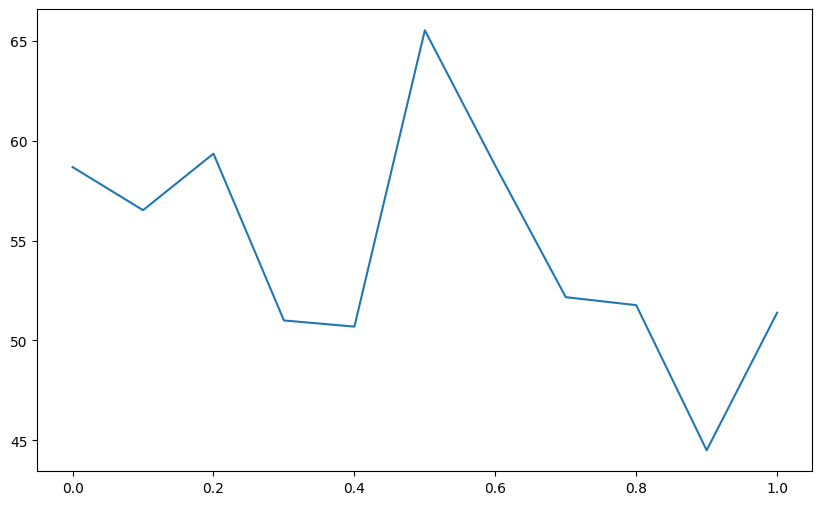

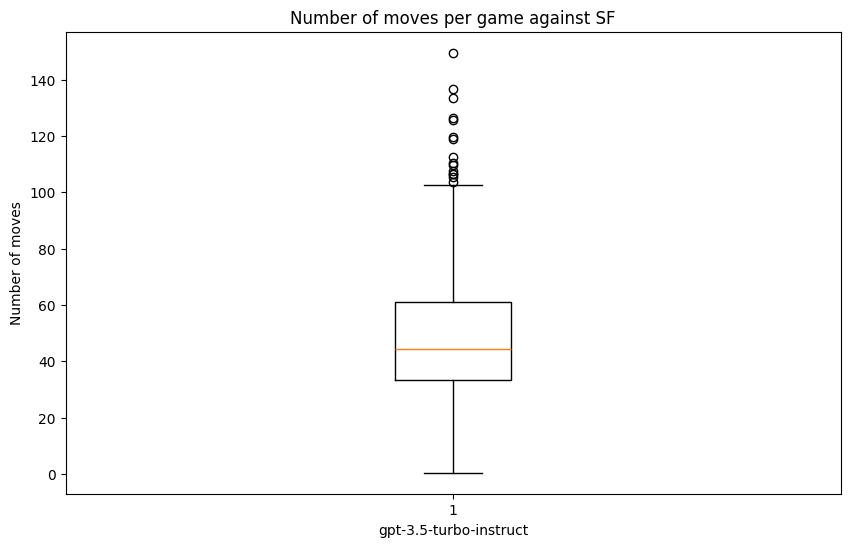

In [25]:
import matplotlib.pyplot as plt

def analyze_games(df_l, model_name):
    # Query for games played by the given model
    model_games = df_l.query(f"(white == '{model_name}' or black == '{model_name}')")
    model_games['nmoves'] = model_games['nmoves'] / 2
    
    # Sum of moves played by the model
    white_nmoves = df_l.query(f"white == '{model_name}'")['nmoves'].sum() / 2
    black_nmoves = df_l.query(f"black == '{model_name}'")['nmoves'].sum() / 2
    t_moves = model_games['nmoves'].sum()

    temp_tab = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

    # Count of illegal moves
    illegal_moves = len(df_l.query(f"(white == '{model_name}' or black == '{model_name}') and has_illegal == True"))
    illegal_moves_10 = len(df_l.query(f"(white == '{model_name}' or black == '{model_name}') and has_illegal == True and illegal_move != '1-0'"))

    df_t = [model_games.query("has_illegal==False and `temperature`=={}".format(round(t,1))) for t in temp_tab ]

    # Printing results
    print("illegal moves", round(illegal_moves/t_moves, 5)*100, "%")
    print("illegal_moves without 1-0:", round(illegal_moves_10/t_moves, 5)*100, "%")
    print("Total number of moves played by", model_name, ":", t_moves)
    print("White played", white_nmoves, "moves")
    print("Black played", black_nmoves, "moves")
    print("Number of moves against SF")
    print("The longest game was", model_games['nmoves'].max(), "moves")
    print("The shortest game was", model_games['nmoves'].min(), "moves")
    print("The average game length was", model_games['nmoves'].mean(), "moves")
    print("The median game length was", model_games['nmoves'].median(), "moves")
    x =[]
    y =[]
    for i in range(11) :
        x.append( temp_tab[i])
        y.append(df_t[i]['nmoves'].mean())
        print("The mean game length for temperature {} is {} moves".format(x[i], y[i]))

    plt.figure(figsize=(10, 6))
    plt.plot(x, y)
    plt.show()

    # Plotting box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(model_games['nmoves'])
    plt.title(f"Number of moves per game against SF")
    plt.ylabel("Number of moves")
    plt.xlabel(f"{model_name}")
    plt.savefig(f"{model_name}_games_nmoves.png", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
analyze_games(df, 'gpt-3.5-turbo-instruct')




In [26]:
def compute_average(df, model_name='gpt-3.5-turbo-instruct'):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Convert Elo columns to numeric, setting errors='coerce' to handle non-numeric values
    df_copy['white_elo'] = pd.to_numeric(df_copy['white_elo'], errors='coerce')
    df_copy['black_elo'] = pd.to_numeric(df_copy['black_elo'], errors='coerce')

    # Filter out rows where gpt-3.5-turbo-instruct is the player and get the opponent's Elo
    opponent_elo_white = df_copy[df_copy['white'] == model_name]['black_elo']
    opponent_elo_black = df_copy[df_copy['black'] == model_name]['white_elo']

    # Concatenate the Elo ratings of opponents when gpt-3.5-turbo-instruct played as white and black
    all_opponent_elo = pd.concat([opponent_elo_white, opponent_elo_black])

    # Calculate the average Elo rating of the opponents, excluding missing or NaN values
    average_opponent_elo = all_opponent_elo.mean()

    return average_opponent_elo


In [27]:
from scipy.optimize import fsolve


def computation_Elo(df,  initial_guess = 1700, model_name='gpt-3.5-turbo-instruct', K=400):
    # Given values
    S_A = compute_score(df, model_name)  # The score of Player A
    R_B = compute_average(df, model_name)  # The rating of Player 

    # Define the equation to solve for R_A
    def equation(R_A, *data):
        S_A, R_B = data
        return S_A - 1 / (1 + 10**((R_B - R_A) / K)) 

    # Solve the equation for R_A
    R_A_solution = fsolve(equation, initial_guess, args=(S_A, R_B))

    # Extract the calculated R_A value
    R_A_calculated = float(R_A_solution[0])
    return R_A_calculated

print("global elo : {}".format(computation_Elo(df)))
for t in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    print("t={} elo : {}".format(t,computation_Elo(df.query("temperature == "+str(t)))))


global elo : 1797.0166779013011
t=0.0 elo : 1816.9045153489294
t=0.1 elo : 1920.3041927172796
t=0.2 elo : 1934.590413623927
t=0.3 elo : 1952.995566741915
t=0.4 elo : 1790.981636567251
t=0.5 elo : 1872.6296296296296
t=0.6 elo : 1625.7096464757499
t=0.7 elo : 1718.4892770840904
t=0.8 elo : 1605.9419609156234
t=0.9 elo : 1616.704898361158
t=1.0 elo : 1651.8727822598903


In [29]:

def lookup_fide_table(score):
        # Data here: https://handbook.fide.com/chapter/B022017
        data = {
            'p': [1.0, .99, .98, .97, .96, .95, .94, .93, .92, .91, .90, .89, .88, .87, .86, .85, .84,
                .83, .82, .81, .80, .79, .78, .77, .76, .75, .74, .73, .72, .71, .70, .69, .68, .67,
                .66, .65, .64, .63, .62, .61, .60, .59, .58, .57, .56, .55, .54, .53, .52, .51, .50,
                .49, .48, .47, .46, .45, .44, .43, .42, .41, .40, .39, .38, .37, .36, .35, .34, .33,
                .32, .31, .30, .29, .28, .27, .26, .25, .24, .23, .22, .21, .20, .19, .18, .17, .16,
                .15, .14, .13, .12, .11, .10, .09, .08, .07, .06, .05, .04, .03, .02, .01],
            'dp': [800, 677, 589, 538, 501, 470, 444, 422, 401, 383, 366, 351, 336, 322, 309, 296, 284,
                273, 262, 251, 240, 230, 220, 211, 202, 193, 184, 175, 166, 158, 149, 141, 133, 125,
                117, 110, 102, 95, 87, 80, 72, 65, 57, 50, 43, 36, 29, 21, 14, 7, 0, -7, -14, -21, 
                -29, -36, -43, -50, -57, -65, -72, -80, -87, -95, -102, -110, -117, -125, -133, -141,
                -149, -158, -166, -175, -184, -193, -202, -211, -220, -230, -240, -251, -262, -273, 
                -284, -296, -309, -322, -336, -351, -366, -383, -401, -444, -470, -501, -538, -589, -677, -800]
        }

        # Convert to DataFrame
        df_fide = pd.DataFrame(data)

        rscore = round(score, 2)

        # lookup score in table
        dp = df_fide.loc[df_fide['p'] == rscore, 'dp'].iloc[0]
        return dp

def fide_elo_computation(dfe, model_name, score=None):
    average_opponents_ratings = compute_average(dfe, model_name)
    if score is None:
        score = compute_score(dfe, model_name)
    dp = lookup_fide_table(score)


    return average_opponents_ratings + dp

                    
def compute_elo(df_l, model_gpt_name):
    df_elo = df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and `has_illegal` == False")
    fide_elo_value = round(fide_elo_computation(df_elo, model_gpt_name), 0)
    print(f"{fide_elo_value} Elo for {model_gpt_name} against SF and only with legal games/moves")
    
    df_elo_withillegal = df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")
    s, t = compute_score(df_elo_withillegal, model_gpt_name, percentage=False)
    sc = s / len(df_elo_withillegal)
    fide_elo_with_illegal_value = round(fide_elo_computation(df_elo_withillegal, model_gpt_name, sc), 0)
    print(f"{fide_elo_with_illegal_value} Elo for {model_gpt_name} against SF and with all games")

# Usage:
compute_elo(df, 'gpt-3.5-turbo-instruct')
for t in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    print("temperature == "+str(t))
    compute_elo(df[df["temperature"] == t], 'gpt-3.5-turbo-instruct')





1790.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1652.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
temperature == 0.0
1819.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1736.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
temperature == 0.1
1912.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1844.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
temperature == 0.2
1930.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1778.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
temperature == 0.3
1942.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1873.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
temperature == 0.4
1789.0 Elo for gpt-3.5-turbo-instruct against SF and only with legal games/moves
1622.0 Elo for gpt-3.5-turbo-instruct against SF and with all games
temperature